In [ ]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Random walk

A **random walk** is the process by which a randomly-moving object or a *walker* wander away from where they started. The concept of random walk started in classical computations and later redefined in quantum computations.

Initially we discuss the concept of **classical random walk**, and later focus on the **quantum random walk**.

## Classical random walk

There are two kinds of random walks; if the jumps are continous we call it **continuous random walk** and if it's discrete or integer, it is called **discrete random walk**. In this document we will focus mainly on the discrete random walk.

One of the models for random walk is a simple random walk on an integer lattice $Z^{d}$, aka integer random walk. 
In most of the models, at each time step(unit), a random walker makes a random move of length one in one of the lattice directions. 

If $d=1$, the lattice is one dimensional and the walker moves on a line. It has been portrayed as the walker flips a fair coin and moves one step to the right or one step to the left depending on whether the coin comes up, heads or tails. To simulate and animate the evolution of probability distribution of random walk on a line with a limited number of resources (bits), naturally we assume the line has a limited number of nodes, also the ending point (the righmost point) is leading to the starting point (the leftmost point), which converts the line into a circle. 

We let $S_N$ denote the position of the walker at time $N$. If we assume that the walker starts at $x$, we can write
$S_N = x + X_1 + ···+ X_N$
where $X_1$, $X_2$, . . ., $X_N$ are independent random variables with $P\{X_j = +1\}= p$, and $P\{Xj= -1\} = 1-p$, (in fair coin walk $p=0.5$).

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit_aer import Aer
from qiskit.circuit.library import CU3Gate

To simplify, let the initial position of our walker be $x=\overrightarrow 0$. This model of a random walk can be generalized to $d$-dimensions.
To find the updated position vector of our walker, we compute the value:

$$S_N \ = \ \displaystyle\sum_{k \ = \ 1}^{N} \ X_k$$

For a coin 1-dimensional random walk, the probability distribution of the walker being at a specific location follows a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). 

At each point, if $L$ is the number of steps to the left, and $R$ is the number of steps to the right ($N \ = \ L \ + \ R$), then the probability 
of taking $L$ steps to the left and $R$ steps to the right is $P(N,R, L) = p^R (1 - p)^L$.

Assume the position of the walker is at $X$, naturally $X= R - L$.
So for any $X$, the position of the walker is determined by the number of right steps, 
minus the number of left steps.
To find the total probability of being at location $X$, $P_{N}(X)$, we have to multiply the probability $P(L, R, L)$ by the number of possible ways of $R$ right steps (which leads to $L$ left steps) in all possible sequences. 
We *choose* $R$ from $N$ possible steps which leaves $N - R$ left steps):
$$P_{N}(X)=\begin{pmatrix} N \\ R \end{pmatrix} \ p^R (1 - p)^{N - R}$$
Since, $X = R - L$ also  $N = R + L $, thus $R = \frac{N + X}{2}$ and $L = \frac{N - X}{2}$, therefore:
$$ P_{N}(X) = \begin{pmatrix} N \\ \frac{N + X}{2} \end{pmatrix} \ p^{\frac{N + X}{2}} (1 -  p)^{\frac{N - X}{2}}$$
To have an integer value in the terms $R = \frac{N + X}{2}$ and $L = \frac{N - X}{2}$, either both $N$ and $X$ has to be *even* or both has to be *odd*. If this is not the case ($N$ even and $X$ odd or $N$ odd and $X$ even), then $P_{N}(X) = 0$.

Therefore the probability distribution of a classical $N$ step random walk is a binomial distribution on the domain of the even or the odd numbers.

We will later show that the probability distribution of a simulated 1-dimensional quantum walk is not similar to the binomial distribution.

To simulate this, we start from point $0$, then repeatedly *flip a coin*, and move left and right accordingly:

In [45]:
N = 50    # Total number of steps
p = 0.5  # Probability of moving right
i = 0     # Initial position
# Generating N random walk (p weighted) and updating the position
def random_walk(p, N, i):
    position = i
    for j in range(0, N): 
        coin_flip = list(np.random.choice(2, 1, p=[1-p, p])) # p weighted random (0,1)
        position += 2*coin_flip[0]-1 # Converting (0,1) to (-1, +1) and adding to position
    return position

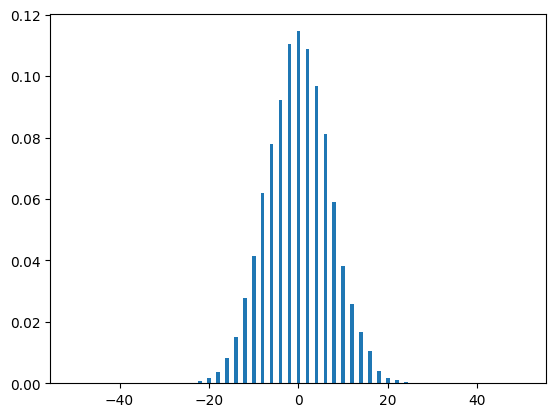

In [46]:
def dist(runs, N):
    positions = range(-1*N, N+1) 
    instances = [0 for i in range(-1*N, N+1)]
    
    for k in range(0, runs):

        result = random_walk(p, N, i)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n/runs for n in instances])
    plt.show()
    
dist(10000, N)

## Quantum walk 
The main concept of quantum walk is quite similar to the  classical random walk, though 
the observed results of the two processes have many differences. 
As you saw earlier, the distribution of a classical walk is a binomial distribution which has a variance in the form of $\sigma^2 = N p (1-p) \sim N$. In some texts the number of random walks is called number of time-steps $T$, thus $\sigma^2 \sim T$.

For the quantum walk, we will see that $\sigma^2 \sim N^2 \sim T^2$. That means, the standard deviation of quantum walk grows quadratically faster than the standard deviation of a classical random walk and quantum random walk spreads quadratically faster than classical random walk.

In general, we assume the random walk is operated on an arbitrary undirected graph $G(V,E)$ where $V = {v_1, v_2, ..v_n}$ are nodes and $E = {(v_x, v_y) , ( v_i, v_j) …}$ represent edges.

In this notebook we conduct a quantum random walk on a circular graph which can be efficiently implemented on a quantum circuit. 

 <img src="CircularGraph.png" alt="Circular Graph" style="width: 400px;"/>

We use a Hadamard gate for executing the coin function since it puts our qubits in a state of superposition, allowing for the  simulation of a coin based probability:

$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

Unitary operations are made of coin and shift operators $U = SC$.



The quantum walk extends into a position space where each node $v_i$ has a certain valency $d_i$ and is split into $d_i$ subnodes. The shifting operator then acts as $S (v_i, a_i) = (v_j, a_j)$ and with the coin operator, are unitary gates which combine the probability amplitudes with individual subnodes under each node.

A unitary of $v_i$ with valency $d_i$ can be represented as $(d_i \times d_i)$. The total state of system is defined by the Hilbert space 
$$H = H_c + H_p$$ 
in which $H_p$ is the position Hilbert space spanned by the set:
$$H_p  =  \{\lvert j\rangle : j = 0, ..., 2^n - 1 \}$$
and  $H_C$ is the coin Hilbert space spanned by:
$$H_C  =  \{\lvert i\rangle  :  i  =  \downarrow,  \uparrow\rangle\}$$
By combining the two operators: $$S  = U (H  \otimes  I)$$

The operations (walks) propagate around the graph as each node represents a seperate bit-string value. Naturally for any $2^n$ size graph, $n$ qubits are required to encode the bit-strings and 1 extra qubit is also needed for coin operation.

<img src="RandomWalkCirc1.png" alt="Quantum Random Walk Circuit" style="width: 700px;"/>

The above is the circuit for the the quantum walk on the cycle graph with $2^3$ nodes. There, q[0], q[1] and q[2] represent the state of the quantum walker, and q[3] represents the coin operator.
The initial position of the walker is the initial state of the first 3 qubits and can be set to any state. 
The coin operator decides whether the walker proceeds clockwise or counterclockwise.
INC is the gate that increments the state of the walker (clockwise rotation) and DEC is the gate that decrements the state (counterclockwise rotation). 

To implement INC and DEC gates, we need to implement Toffoli gates.

<img src="INC-DEC.png" alt="Increment Decrement Gates from Toffoli" style="width: 500px;"/>

c$n$x can be represented using c($n-1$)x in a recursive approach.

In [54]:
def cnx(qc, *qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        # A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        qc.append(CU3Gate(np.pi/2, 0, 0), [qubits[-2],qubits[-1]])

        # Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # B matrix (pposite angle)
        qc.append(CU3Gate(-np.pi/2, 0, 0), [qubits[-2], qubits[-1]])
        
        # Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

In [55]:
n=3 #setting the number of qubits required
# Importing required qiskit modules
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

In [56]:
# Uncomment this code to run using qasm simulator backend in IBM Quantum
#my_provider = IBMQ.load_account()
#backend = my_provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2023-04-27 12:17:15,956: Credentials are already in use. The existing account in the session will be replaced.


In [64]:
backend = Aer.get_backend("qasm_simulator")

We then need to execute the increment and decrement gate in order for the shift operator to walk, including the c$n$x gates which changes the position of the walker based on the coin operator.

In [65]:
def increment_gate(qwc, q, subnode):
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  cnx(qwc, subnode[0], q[2], q[1])
  cnx(qwc, subnode[0], q[2])
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):
  qwc.x(subnode[0])
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1])
  qwc.x(q[2])
  cnx(qwc, subnode[0], q[2])
  qwc.x(subnode[0])
  return qwc
  
def ibmsim(circ):
  print(circ)
  job = backend.run(circ, run_options={'shots': 1000})
  job.result()
  return backend.run(circ, run_options={'shots': 1000}).result().get_counts(circ)

<!-- ## Quantum Walk on Hypercube Graph
The hypercube of dimension $d$ is a graph with degree $d$ in each node. hence we need a $d$-dimensional direction space as well.

<img src="hypercube.png" alt="Quantum Random Walk On Hypercube" style="width: 400px;"/>

- Define coin matrices and dimension of hypercobe
- Create the hypercube graph.
- Execute quantum random walk on hypercube. -->

In [66]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)


def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes)
        decrement_gate(qwc,qnodes,qsubnodes)
        qwc.measure(qnodes, cnodes)

    return qwc

In [67]:
step = 1
qwc = runQWC(qwc, step) 
qwc.draw(output="mpl")
result = ibmsim(qwc)
print(result)

        ┌─────────┐┌─────────────┐┌─────────┐┌─────────────┐┌───┐»
  qc_0: ┤ Rz(π/2) ├┤ U3(π/2,0,0) ├┤ Rz(π/2) ├┤ U3(π/2,0,0) ├┤ X ├»
        └────┬────┘└──────┬──────┘└────┬────┘└──────┬──────┘└─┬─┘»
  qc_1: ─────■────────────■────────────┼────────────┼─────────┼──»
                                       │            │         │  »
  qc_2: ───────────────────────────────■────────────■─────────┼──»
           ┌───┐                                              │  »
  qanc: ───┤ H ├──────────────────────────────────────────────■──»
           └───┘                                                 »
  cr: 3/═════════════════════════════════════════════════════════»
                                                                 »
canc: 1/═════════════════════════════════════════════════════════»
                                                                 »
«        ┌──────────────┐┌───┐┌──────────┐┌──────────────┐┌─────────┐»
«  qc_0: ┤ U3(-π/2,0,0) ├┤ X ├┤ Rz(-π/2) ├┤ U3(-π/2,0,0) ├

In [68]:
def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)
    return qwc

The first qubit is always 0 and represents the coin qubit.

The second to fourth qubits are binary-code of the position of the walker.
The distribution of the quantum walk on a circle graph can be seen.

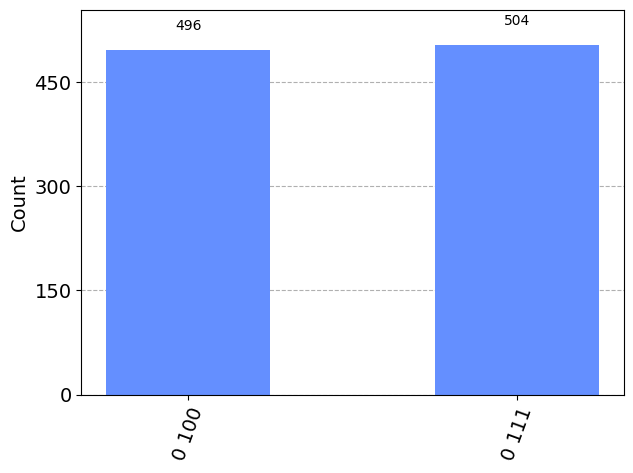

In [69]:
#result = ibmsim(qwc)
plot_histogram(result)

The following animation is what the quantum walk looks like over its 19 iterations. The size of each node represents probability of the quantum walker existing in that position. 

<img src="fast.gif" alt="15 iteration" align="center" style="width: 200px;"/>

The implemented algorithm requires $n+1$ qubits for any cycle graph with $2^n$ nodes.

## Quantum walk based algorithms

The quantum random walk formulation has considerable flexibility and opportunities for development of other quantum algorithms; among them are quantum Walk based search and quantum walk based optimization algorithms.

### Quantum walk search

Quantum random walks on graphs have many interesting properties, including exponentially fast hitting times compared with their classical counterparts. However, it is still unclear how to use these novel properties to gain an algorithmic speed-up over classical algorithms.

Quantum walk search refers to the use of quantum walks to solve a search problem on a graph.
There are some search algorithm based on the quantum random walk architecture that provides such a speed-up. Several researchers have shown algorithms that perform an oracle search on a database of $N$ items with $O(\sqrt N)$ calls to the oracle, yielding a quadratic speed-up similar to Grover quantum search algorithm. 

### Quantum walk optimization algorithm

As you recall from QAOA section, quantum approximate optimization algorithm  works by iteratively applying two unitary operators (the phase unitary and the mixing unitary) to an initial state (which is equally weighted quantum superposition of all states), then reading the states, and then optimizing the unitary parameters classically, so as to steer the quantum amplitude in each step into the ground state solutions. 

Quantum Walk Optimization Algorithm (QWOA),instead, makes use of alternating quality-dependent phase shifts (phase unitary) and continuous-time quantum walks (CTQWs) over a circulant graph (similar to above) connecting all possible solutions in the solutions space.
By tuning the applied phase-shifts and quantum walks (classical parameters), the hope is that quantum interference will result in a concentration of probability density at states corresponding to higher quality solutions. This tuning process is carried out via a classical optimization procedure which optimizes for the expectation value of quality, as measured from the quantum circuit. The number of lattice points (the search space) in QAOA is $2^{2n}$  while in
QAOAz is ${C}_{n+A}^{2n}$ ($A$ is the requested cardinality). The number of lattice points for QWOA is a recursive equation but proven to be an exponential with lower slope that the other two methods. As a drawback, QWOA has a quadratic increase in mixing circuit complexity compared with QAOA.

![alt text](QWOA1_Circ.png "Quantum Walk Optimization Algorithm Circuit")

## References

<a id='Kempe2003'></a> 1. Julia Kempe. [Quantum random walks - an introductory overview](https://arxiv.org/abs/quant-ph/0303081). *arXiv* 2003

<a id='Shenvi2003'></a> 2. Neil Shenvi, Julia Kempe, K. Birgitta Whaley. [A Quantum Random Walk Search Algorithm](https://arxiv.org/abs/quant-ph/0210064). *arXiv* 2003

<!-- [3] Bertsimas, D. & Vempala, S. Solving convex programs by random walks. J. ACM 51, 540–556 (2004). -->
<a id='Marsh2020'></a> 3. S. Marsh and J.B. Wang, [Combinatorial optimization via highly efficient quantum walks](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023302). *Physical Review Research* 2(2020).

<a id='Qiskit'></a> 4. [Qiskit Random Walk Tutorial](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/terra/qis_adv/quantum_walk.ipynb). *Qiskit* 

<a id='Cirq'></a> 5. [Cirq Quantum Walk Tutorial](https://quantumai.google/cirq/tutorials/quantum_walks). *Cirq*

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>